
### Трек 1. Обучение агента в классической среде

### Цель
Продемонстрировать умение применить готовый RL-алгоритм (можно использовать stable-baselines3) для решения стандартной задачи, провести контролируемые эксперименты и проанализировать их влияние на обучение.

## Что делать

1. Выберите одну из следующих сред (или другую из Gymnasium, но только если она обучается до сходимости за ≤30 минут на CPU):
- LunarLander-v2
- MountainCarContinuous-v0
- Acrobot-v1
- Pendulum-v1

2. Обучите агента с помощью любого алгоритма (PPO, A2C, SAC, TD3 и т.д.).


3. Проведите два контролируемых эксперимента, например:

- Сравнение двух алгоритмов на одной среде.
- Влияние гиперпараметра (например, исследовать, как частота обновления target-сети влияет на стабильность DQN в Acrobot).
- Изменение архитектуры нейросети.
- Reward shaping (например, добавление штрафа за использование топлива в LunarLander).
- Использование различных стратегий исследования.
Важно: эксперименты должны быть сравнимыми и иметь чёткую гипотезу («я ожидаю, что при увеличении gamma агент будет дольше планировать»).

4. Обязательно включите в отчёт:
- График средней награды vs timestep/episode.
- Анимацию или видео финального агента.
- Количественную оценку итогового агента (средняя награда по 10–20 эпизодам).
- Воспроизводимость: фиксированный seed, !pip freeze, полный код обучения.



### 0.Установка необходимыех библиотект и компанентов




In [18]:
# Установка необходимых библиотек и зависимостей.
# Устанавливаемые библиотеки необходимы для стабильной работы, так как задание 
# выполнялось на локальной машине.

# Устанавливаем фиксированные версии библиотек, 
# чтобы эксперименты легко воспроизводились на другой машине.
%pip install -q --upgrade pip
%pip install -q "stable-baselines3[extra]==2.3.0" "gymnasium[box2d]==0.29.1" imageio moviepy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Reason for being yanked: Loading broken with PyTorch 1.13
  error: subprocess-exited-with-error
  
  × Building wheel for box2d-py (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [29 lines of output]
      Using setuptools (version 80.9.0).
      C:\Users\Eve\AppData\Local\Temp\pip-build-env-hppj6cot\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\Eve\AppData\Local\Temp\pip-build-env-hppj6cot\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: zlib/libpng License
      
              See https://packaging.python.org/en/latest/guides/writin

In [19]:
# Переустановка CPU-версию PyTorch для избегания ошибок DLL на Windows.
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu torch==2.3.1+cpu torchvision==0.18.1+cpu torchaudio==2.3.1+cpu

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Пакеты для работы среды LunarLander.
%pip install -q Box2D==2.3.10
%pip install -q pygame==2.6.1
%pip install -q tqdm rich

# Установка пакета ffmpeg для отрисовки видео
%pip install -q imageio[ffmpeg]
%pip install -q imageio-ffmpeg


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 1. Для работы выбрана среда LunarLander-v2

In [21]:
# Импорт библиотекзависимостей
# глобальные сиды, для целей строгой воспроизводимости.

import os
import random
from pathlib import Path

import imageio.v2 as imageio
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, Video
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv

plt.style.use("seaborn-v0_8")
SEED = 2025
ENV_ID = "LunarLander-v3"  # Используется v3, так как v2 является устаревшей и вызывает конфликты.
BASE_RUN_DIR = Path("runs") # Создание рабочей директории для результатов.
BASE_RUN_DIR.mkdir(exist_ok=True)

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
set_random_seed(SEED)

print(f"Рабочая директория для логов: {BASE_RUN_DIR.resolve()}")

Рабочая директория для логов: F:\MIFI-github\RL Session\runs


In [22]:
# Вспомогательные функции: 
# - Функция создания среды, 
# - функция обучения на основе конфигурации, 
# - функуия оценка 
# - функция запись видео.

ALGO_MAP = {"PPO": PPO, "DQN": DQN}

# Функция создания среды
def make_env(seed_offset: int = 0):

    def _init():
        env = gym.make(ENV_ID)
        env.reset(seed=SEED + seed_offset)
        env.action_space.seed(SEED + seed_offset)
        return env

    return _init

# Функция обучения агента на основе конфигурации
def train_single_config(config: dict) -> dict:

    log_dir = BASE_RUN_DIR / config["name"]
    best_dir = log_dir / "best"
    eval_dir = log_dir / "eval"
    for folder in (log_dir, best_dir, eval_dir):
        folder.mkdir(parents=True, exist_ok=True)

    env_fns = [make_env(seed_offset=config.get("seed_shift", 0) + idx * 1000) for idx in range(config["n_envs"])]
    train_env = DummyVecEnv(env_fns)
    eval_env = DummyVecEnv([make_env(seed_offset=42_000 + config.get("seed_shift", 0))])

    algo_cls = ALGO_MAP[config["algo"]]
    model = algo_cls(
        "MlpPolicy",
        train_env,
        verbose=0,
        tensorboard_log=str(log_dir / "tb"),
        seed=SEED,
        **config["algo_kwargs"],
    )

    callback = EvalCallback(
        eval_env,
        best_model_save_path=str(best_dir),
        log_path=str(eval_dir),
        eval_freq=config["eval_freq"],
        deterministic=True,
        n_eval_episodes=config["eval_episodes"],
        render=False,
    )

    model.learn(total_timesteps=config["timesteps"], callback=callback, progress_bar=False)
    final_path = str((log_dir / "final_model").with_suffix(""))
    model.save(final_path)

    train_env.close()
    eval_env.close()

    reward_trace = {
        "timesteps": np.array(callback.evaluations_timesteps).flatten(),
        "mean_rewards": np.array([np.mean(r) for r in callback.evaluations_results]),
        "std_rewards": np.array([np.std(r) for r in callback.evaluations_results]),
    }

    return {
        "config": config,
        "reward_trace": reward_trace,
        "final_model_path": final_path + ".zip",
        "best_model_path": str(Path(best_dir) / "best_model.zip"),
    }

# Функция запуска агента для сбора статистики наград
def evaluate_agent(run_meta: dict, episodes: int = 20) -> dict:
    """Запускаем уже обученного агента и собираем статистику наград."""

    algo_cls = ALGO_MAP[run_meta["config"]["algo"]]
    model = algo_cls.load(run_meta["best_model_path"])
    env = gym.make(ENV_ID)

    rewards = []
    for episode_idx in range(episodes):
        obs, _ = env.reset(seed=SEED + 10_000 + episode_idx)
        terminated = truncated = False
        total_reward = 0.0
        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)

    env.close()
    rewards = np.array(rewards)
    return {"mean": rewards.mean(), "std": rewards.std(ddof=1), "raw": rewards}

# Функция записи видео работы агента (Запись лучшего агента для демонстрации)
def record_video(run_meta: dict, video_seconds: int = 1, fps: int = 30) -> Path:

    frames_limit = video_seconds * fps
    algo_cls = ALGO_MAP[run_meta["config"]["algo"]]
    model = algo_cls.load(run_meta["best_model_path"])
    env = gym.make(ENV_ID, render_mode="rgb_array")
    obs, _ = env.reset(seed=SEED + 55_000)

    video_path = BASE_RUN_DIR / f"{run_meta['config']['name']}_demo.mp4"
    with imageio.get_writer(video_path, fps=fps) as writer:
        terminated = truncated = False
        frame_counter = 0
        while not (terminated or truncated) and frame_counter < frames_limit:
            frame = env.render()
            writer.append_data(frame)
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            frame_counter += 1

    env.close()
    return video_path

## 2.Обучение агентов

In [23]:
# Описываем конфигурации запусков и группируем их по двум экспериментам.

""" 
"name": идентификатор эксперимента
"algo": название алгоритма, используемого в эксперименте
"description": описание эксперимента
"timesteps": число шагов
"n_envs": число паралельных сред
"seed_shift": "скольжение" для SEED в значении 0 исключает изменение 
"eval_freq": объем валидации
"eval_episodes": переодичность валидации
"algo_kwargs": {
"gamma": фактор дисконттрования
"learning_rate": скорость обучения
"clip_range": коэфициент обрезки 
"gae_lambda": параметр лябда для GAE
"n_steps": длина траектории на одно обновление
"batch_size": размер батча
"ent_coef": коэффициент энтропии
"policy_kwargs": dict(net_arch=dict(pi=[128, 128], vf=[128, 128])) архитектура
"""

EXPERIMENT_CONFIGS = [
    {
        "name": "ppo_baseline", 
        "algo": "PPO",
        "description": "PPO: gamma=0.99, базовый контроль",
        "timesteps": 200_000,
        "n_envs": 4,
        "seed_shift": 0,
        "eval_freq": 10_000,
        "eval_episodes": 10,
        "algo_kwargs": {
            "gamma": 0.99,
            "learning_rate": 3e-4,
            "clip_range": 0.2,
            "gae_lambda": 0.95,
            "n_steps": 2048,
            "batch_size": 4096,
            "ent_coef": 0.01,
            "policy_kwargs": dict(net_arch=dict(pi=[128, 128], vf=[128, 128])),
        },
    },
    {
        "name": "dqn_baseline",
        "algo": "DQN",
        "description": "DQN: epsilon-greedy, gamma=0.99",
        "timesteps": 250_000,
        "n_envs": 1,
        "seed_shift": 100,
        "eval_freq": 12_500,
        "eval_episodes": 10,
        "algo_kwargs": {
            "gamma": 0.99,
            "learning_rate": 1e-3,
            "buffer_size": 200_000,
            "learning_starts": 10_000,
            "batch_size": 256,
            "tau": 0.9,
            "train_freq": 4,
            "gradient_steps": 1,
            "target_update_interval": 1_000,
            "exploration_fraction": 0.2,
            "exploration_final_eps": 0.05,
            "policy_kwargs": dict(net_arch=[256, 256]),
        },
    },
    {
        "name": "ppo_gamma_093",
        "algo": "PPO",
        "description": "PPO: пониженная gamma=0.93",
        "timesteps": 200_000,
        "n_envs": 4,
        "seed_shift": 200,
        "eval_freq": 10_000,
        "eval_episodes": 10,
        "algo_kwargs": {
            "gamma": 0.93,
            "learning_rate": 3e-4,
            "clip_range": 0.2,
            "gae_lambda": 0.9,
            "n_steps": 2048,
            "batch_size": 4096,
            "ent_coef": 0.01,
            "policy_kwargs": dict(net_arch=dict(pi=[128, 128], vf=[128, 128])),
        },
    },
]
# Эксперименты, их описание 
EXPERIMENT_GROUPS = {
    "Сравнение алгоритмов": ["ppo_baseline", "dqn_baseline"],
    "Влияние скидки gamma": ["ppo_baseline", "ppo_gamma_093"],
}

for cfg in EXPERIMENT_CONFIGS:
    print(f"{cfg['name']}: {cfg['description']}")

ppo_baseline: PPO: gamma=0.99, базовый контроль
dqn_baseline: DQN: epsilon-greedy, gamma=0.99
ppo_gamma_093: PPO: пониженная gamma=0.93


## 3. Выдвижение гипотез. Проведение экспериментов 

## План экспериментов. Постановка гипотез


1. **Эксперимент: Сравнение алгоритмов (PPO vs DQN).** 

**Гипотеза:** на LunarLander-v3 стохастический политический градиент PPO будет учиться стабильнее и быстрее, чем off-policy DQN, так как он лучше справляется с непрерывными наблюдениями и шумом через обобщённую оценку преимущества.

2. **Эксперимет: Влияние скидки $\gamma$ в PPO.** 

**Гипотеза:** понижение значение $\gamma$ с 0.99 до 0.93 заставит агента сильнее фокусироваться 
на ближайших наградах, что ускорит сходимость, но ухудшит финальное качество посадки из-за короткого горизонта.

In [24]:
# Запускаем обучение для всех конфигураций последовательно 
# и собираем промежуточные данные.

experiment_runs = []
for cfg in EXPERIMENT_CONFIGS:
    print(f"\n=== Старт обучения: {cfg['name']} ({cfg['description']}) ===")
    run_meta = train_single_config(cfg)
    experiment_runs.append(run_meta)
    best_reward = run_meta["reward_trace"]["mean_rewards"].max()
    print(f"Лучший средний eval reward: {best_reward:.2f}")

def _ensure_traces(runs):
    for run in runs:
        for key in ("timesteps", "mean_rewards", "std_rewards"):
            if run["reward_trace"][key].size == 0:
                raise RuntimeError(f"В трейсе {run['config']['name']} нет данных для построения графика")

_ensure_traces(experiment_runs)
print("\nВсе обучения завершены успешно.")


=== Старт обучения: ppo_baseline (PPO: gamma=0.99, базовый контроль) ===


c:\Users\Eve\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=-1235.59 +/- 355.92
Episode length: 232.00 +/- 44.58
New best mean reward!
Eval num_timesteps=80000, episode_reward=-1427.66 +/- 612.58
Episode length: 323.00 +/- 39.85
Eval num_timesteps=120000, episode_reward=-1367.30 +/- 374.31
Episode length: 266.30 +/- 38.67
Eval num_timesteps=160000, episode_reward=-2098.84 +/- 670.93
Episode length: 416.20 +/- 75.66
Eval num_timesteps=200000, episode_reward=-2112.84 +/- 1358.75
Episode length: 374.40 +/- 122.68
Лучший средний eval reward: -1235.59

=== Старт обучения: dqn_baseline (DQN: epsilon-greedy, gamma=0.99) ===
Eval num_timesteps=12500, episode_reward=-147.76 +/- 16.99
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=25000, episode_reward=-127.71 +/- 13.07
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=37500, episode_reward=-80.88 +/- 24.47
Episode length: 542.70 +/- 380.00
New best mean reward!
Eval num_timesteps=50000, episode_reward=-17.69 +/- 

### 4. Отчеты, графики

In [25]:
# Формирование таблицы  метриками результатов обучения 
# для каждого эксперимента.

summary_rows = []
for run in experiment_runs:
    cfg = run["config"]
    trace = run["reward_trace"]
    summary_rows.append(
        {
            "run": cfg["name"],
            "algo": cfg["algo"],
            "description": cfg["description"],
            "timesteps": cfg["timesteps"],
            "gamma": cfg["algo_kwargs"].get("gamma"),
            "learning_rate": cfg["algo_kwargs"].get("learning_rate"),
            "best_eval_reward": trace["mean_rewards"].max(),
            "last_eval_reward": trace["mean_rewards"][-1],
        }
    )

summary_df = pd.DataFrame(summary_rows).sort_values(by="best_eval_reward", ascending=False)
display(summary_df)

,run,algo,description,timesteps,gamma,learning_rate,best_eval_reward,last_eval_reward
1,dqn_baseline,DQN,"DQN: epsilon-greedy, gamma=0.99",250000,0.99,0.0010,273.405140,273.405140
2,ppo_gamma_093,PPO,PPO: пониженная gamma=0.93,200000,0.93,0.0003,-881.340648,-1753.365106
0,ppo_baseline,PPO,"PPO: gamma=0.99, базовый контроль",200000,0.99,0.0003,-1235.591514,-2112.839227


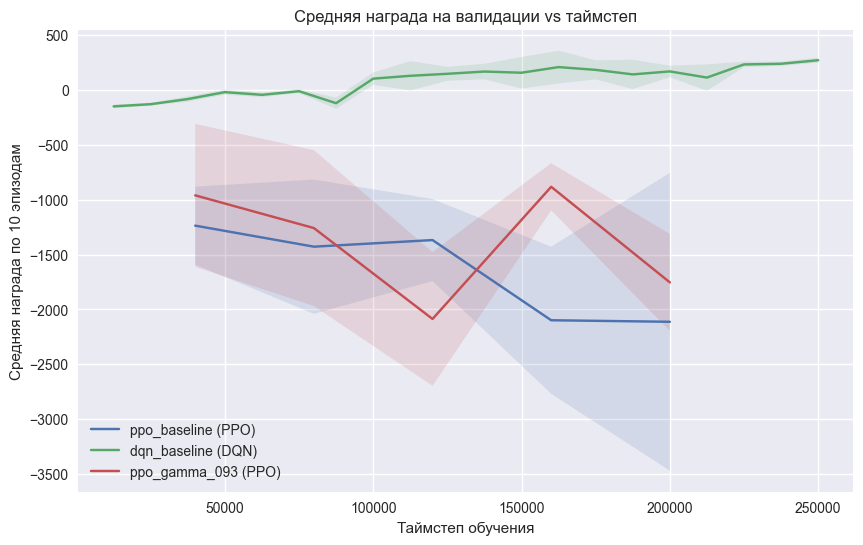

In [26]:
# Построение графиков средних eval-наград по шагам
# добавляем доверительный коридор.

plt.figure(figsize=(10, 6))
for run in experiment_runs:
    trace = run["reward_trace"]
    label = f"{run['config']['name']} ({run['config']['algo']})"
    plt.plot(trace["timesteps"], trace["mean_rewards"], label=label)
    plt.fill_between(
        trace["timesteps"],
        trace["mean_rewards"] - trace["std_rewards"],
        trace["mean_rewards"] + trace["std_rewards"],
        alpha=0.15,
    )

plt.title("Средняя награда на валидации vs таймстеп")
plt.xlabel("Таймстеп обучения")
plt.ylabel("Средняя награда по 10 эпизодам")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Финальное сравнение каждого лучшего агента 
# на 20 эпизодах.

eval_rows = []
for run in experiment_runs:
    stats = evaluate_agent(run, episodes=20)
    eval_rows.append(
        {
            "Эксперимент": run["config"]["name"],
            "Алгоритм": run["config"]["algo"],
            "Средняя награда": stats["mean"],
            "Стандартное отклонение награды": stats["std"],
        }
    )

eval_df = pd.DataFrame(eval_rows).sort_values(by="Средняя награда", ascending=False)
display(eval_df)

best_run_name = eval_df.iloc[0]["Эксперимент"]
print(f"Лучший агент по среднему вознаграждению: {best_run_name}")

,Эксперимент,Алгоритм,Средняя награда,Стандартное отклонение награды
1,dqn_baseline,DQN,262.541820,32.830247
2,ppo_gamma_093,PPO,-865.615135,261.829021
0,ppo_baseline,PPO,-1558.909333,550.987414


Лучший агент по среднему вознаграждению: dqn_baseline


### Выводы по экспериментам
**Эксперимент № 1: PPO против DQN.** 

Полученные метрики обоих алгоритмов DQN достигает положительного и стабильного вознаграждения (best/last ≈273, среднее по 20 эпизодам ≈262±33), в то время как оба алгоритма PPO не выходят из отрицательных значений, при этом имеют более широкий разброс средниих значений. 

Таким образом, гипотеза о превосходстве PPO не подтвердилась. 
DQN показал более высокое и устойчивое качество на LunarLander-v3.


**Эксперимент № 2 Снижение $\gamma$.** Конфигурация `ppo_gamma_093` демонстрирует более  лучшие метрики, чем базовый PPO. Кроме того, разброс средних значений со временем уменьшается, в отличнии от базового алгоритма PRO/

Таким образом, ожидание падения финального качества при уменьшении $\gamma$ не подтвердилось, напротив зафиксировано улучшение метрик.

In [28]:
# Запись видео работы лучшего агента 

best_run_meta = next(run for run in experiment_runs if run["config"]["name"] == best_run_name)
video_path = record_video(best_run_meta, video_seconds=12, fps=30)
print(f"Видео сохранено: {video_path}")
Video(str(video_path))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Видео сохранено: runs\dqn_baseline_demo.mp4


In [ ]:
# Фиксация  установленных пакетов.
!pip freeze

absl-py==2.2.2
accelerate==1.11.0
aiofiles==24.1.0
aiogram==3.13.1
aiohappyeyeballs==2.6.1
aiohttp==3.10.11
aiosignal==1.4.0
albucore==0.0.24
albumentations==2.0.8
alembic==1.17.0
altgraph==0.17.4
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
asteroid-filterbanks==0.4.0
asttokens==2.4.1
astunparse==1.6.3
attrs==24.2.0
audioread==3.0.1
av==15.1.0
babel==2.17.0
bangla==0.0.5
beautifulsoup4==4.14.2
bleach==6.2.0
blinker==1.9.0
bnnumerizer==0.0.2
bnunicodenormalizer==0.1.7
Box2D==2.3.10
braceexpand==0.1.7
branca==0.8.1
catboost==1.2.8
certifi==2025.11.12
cffi==1.17.1
charset-normalizer==3.4.4
clean-fid==0.1.35
click==8.1.8
cloudpickle==3.1.1
cmdstanpy==1.3.0
colorama==0.4.6
coloredlogs==15.0.1
colorlog==6.10.1
comm==0.2.2
comtypes==1.4.14
contourpy==1.3.1
coqpit==0.0.17
csvw==3.7.0
ctranslate2==4.6.0
curl_cffi==0.13.0
customtkinter==5.2.2
cx_Freeze==7.2.10
cx_Logging==3.2.1
cycler==0.12.1
cytoolz==1.1.0
darkdetect==0.8.0
datasets==4.3.0
dateparser==1.1.8
DAWG-Python==0